In [1]:
from data import datasets

quick_draw_dataset = datasets.QuickDrawDataset()
num_images_to_generate = 100000
data_splits = [0.7, 0.2, 0.1]
for i, mode in enumerate(['train', 'val', 'test']):
    datasets.create_composite_dataset((int)(num_images_to_generate * data_splits[i]), mode, quick_draw_dataset)

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import json
from detectron2.data import DatasetCatalog, MetadataCatalog
from data import datasets

dir = 'dataset/composite/'
classes = json.load(open(os.path.join(dir, 'train/labels.json')))

def get_dataset(mode):
    filename = os.path.join(dir, mode + '/data.json')
    with open(filename) as f:
        return json.load(f)

for d in ["train", "val", "test"]:
    DatasetCatalog.register("composite_" + d, lambda d=d: get_dataset(d))
    MetadataCatalog.get("composite_" + d).set(thing_classes=classes)
composite_metadata = MetadataCatalog.get("composite_train")

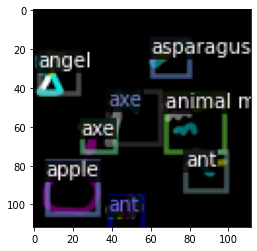

In [3]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

dataset_dicts = DatasetCatalog.get("composite_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=composite_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [4]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
import torch

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("composite_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.NUM_CLASSES = len(classes)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[05/19 09:39:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [13]:
from detectron2.engine import DefaultPredictor
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("composite_val", )
predictor = DefaultPredictor(cfg)

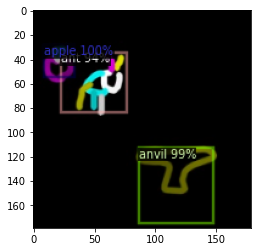

In [17]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_dataset("val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=composite_metadata, 
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

In [25]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("composite_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "composite_val")
inference_on_dataset(trainer.model, val_loader, evaluator)


[05/19 20:00:05 d2.data.datasets.coco]: Converting annotations of dataset 'composite_val' to COCO format ...)
[05/19 20:00:05 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/19 20:00:22 d2.data.datasets.coco]: Conversion finished, #images: 20000, #annotations: 100037
[05/19 20:00:22 d2.data.datasets.coco]: Caching COCO format annotations at './output/composite_val_coco_format.json' ...
[05/19 20:00:26 d2.data.build]: Distribution of instances among all 12 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
|      axe      | 7474         |   asparagus   | 10215        |    arm     | 7419         |
|     angel     | 9094         |      ant      | 7725         |   anvil    | 7677         |
| aircraft ca.. | 7097         | animal migr.. | 8638         |  airplane  | 9276         |
|  alarm clock  | 7587         |   ambulance  

OrderedDict([('bbox',
              {'AP': 58.13134743029678,
               'AP50': 83.0386580342606,
               'AP75': 63.56539032948356,
               'APs': 32.66186238324991,
               'APm': 59.32817345474377,
               'APl': 50.29490737060669,
               'AP-axe': 45.19308166494527,
               'AP-asparagus': 38.14031189896076,
               'AP-arm': 59.72236295095299,
               'AP-angel': 66.41870368447177,
               'AP-ant': 61.69814926901238,
               'AP-anvil': 69.63944111350868,
               'AP-aircraft carrier': 45.78354999770931,
               'AP-animal migration': 44.93958693643586,
               'AP-airplane': 68.12452711596522,
               'AP-alarm clock': 58.47536956562301,
               'AP-ambulance': 74.32053194621521,
               'AP-apple': 65.12055301976079})])